In [14]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression , LinearRegression
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, mean_squared_error, r2_score
import statsmodels.api as sm 
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.svm import SVC 
from sklearn.model_selection import GridSearchCV 
from sklearn.impute import SimpleImputer 
import matplotlib.pyplot as plt 
import yfinance as yf  
import sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from xgboost import XGBClassifier
import itertools 
from PIL.GimpGradientFile import linear
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.impute import SimpleImputer


In [4]:
sofi = pd.read_csv('SOFI.csv', parse_dates=['Date'], index_col='Date')
sofi.dropna()

,Close,Dividends,High,Low,Open,Stock Splits,Volume
Date,,,,,,,
2024-01-22,7.920000,0.0,8.330000,7.72,7.83,0.0,69046700.0
2024-01-23,7.750000,0.0,8.140000,7.73,8.10,0.0,45600700.0
2024-01-24,7.560000,0.0,7.940000,7.53,7.89,0.0,41431000.0
2024-01-25,7.650000,0.0,7.750000,7.55,7.66,0.0,49509400.0
2024-01-26,7.620000,0.0,7.830000,7.52,7.69,0.0,72566000.0
...,...,...,...,...,...,...,...
2025-01-10,14.150000,0.0,14.280000,13.81,14.20,0.0,33470100.0
2025-01-13,14.070000,0.0,14.085000,13.60,13.64,0.0,32197100.0
2025-01-14,14.500000,0.0,14.860000,14.23,14.30,0.0,34100800.0


Train Test Split Function

In [ ]:
def train_test_split_macd(df):

    # Define the training and trading periods
    train_start, train_end = '2024-01-17', '2024-02-29'
    trade_start, trade_end = '2024-03-01', '2025-01-16'

    # Filter the dataset for the training and trading periods
    df_train = df[(df['Date'] >= train_start) & (df['Date'] <= train_end)].copy()
    df_trade = df[(df['Date'] >= trade_start) & (df['Date'] <= trade_end)].copy()

    return df_train, df_trade

MACD Strategy 

C:\Users\ASUS\AppData\Local\Temp\ipykernel_27220\4128585963.py:22: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Returns'] = df['Close'].pct_change().fillna(0)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27220\4128585963.py:22: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Returns'] = df['Close'].pct_change().fillna(0)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27220\4128585963.py:22: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_

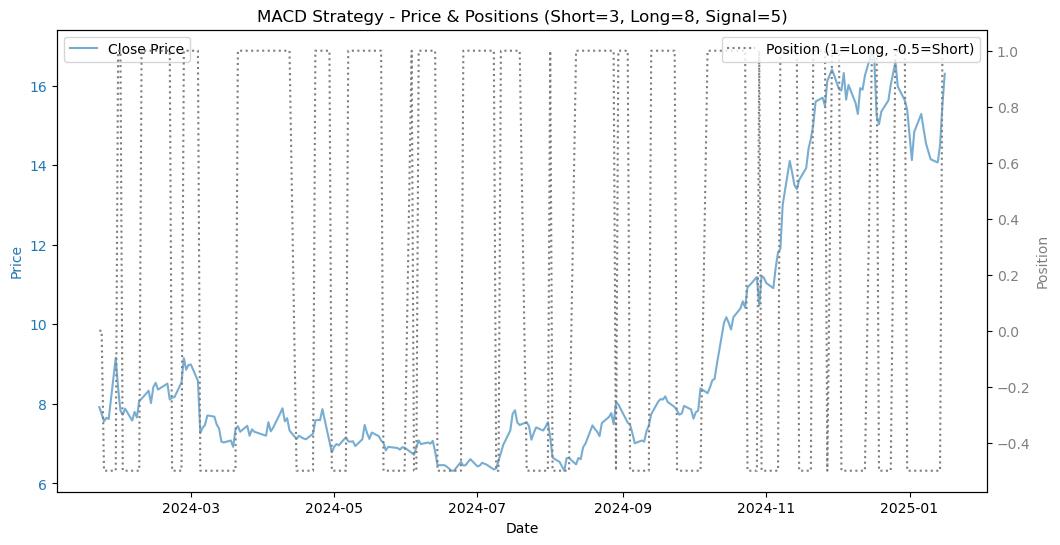

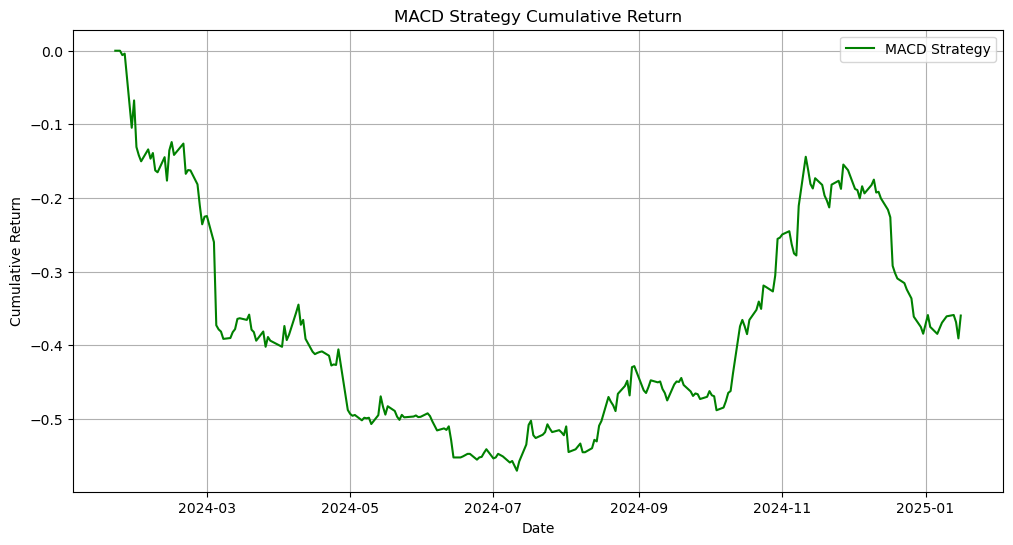

Short EMA	Long EMA	Signal EMA	Total Return
3		8		5		-35.97%
3		8		6		-35.97%
3		8		7		-35.97%
3		9		5		-35.97%
3		9		6		-35.97%
3		9		7		-35.97%
3		10		5		-35.97%
3		10		6		-35.97%
3		10		7		-35.97%
3		11		5		-35.97%
3		11		6		-35.97%
3		11		7		-35.97%
4		8		5		-35.97%
4		8		6		-35.97%
4		8		7		-35.97%
4		9		5		-35.97%
4		9		6		-35.97%
4		9		7		-35.97%
4		10		5		-35.97%
4		10		6		-35.97%
4		10		7		-35.97%
4		11		5		-35.97%
4		11		6		-35.97%
4		11		7		-35.97%
5		8		5		-35.97%
5		8		6		-35.97%
5		8		7		-35.97%
5		9		5		-35.97%
5		9		6		-35.97%
5		9		7		-35.97%
5		10		5		-35.97%
5		10		6		-35.97%
5		10		7		-35.97%
5		11		5		-35.97%
5		11		6		-35.97%
5		11		7		-35.97%
6		8		5		-35.97%
6		8		6		-35.97%
6		8		7		-35.97%
6		9		5		-35.97%
6		9		6		-35.97%
6		9		7		-35.97%
6		10		5		-35.97%
6		10		6		-35.97%
6		10		7		-35.97%
6		11		5		-35.97%
6		11		6		-35.97%
6		11		7		-35.97%

Best MACD parameters for SOFI: Short=3, Long=8, Signal=5 with Total Return: -35.97%


In [ ]:
# Function to calculate MACD and Signal Line with fixed parameters
def calculate_macd(df, short_window=4, long_window=9, signal_window=6):
    df['EMA_Short'] = df['Close'].ewm(span=short_window, adjust=False).mean()
    df['EMA_Long'] = df['Close'].ewm(span=long_window, adjust=False).mean()
    df['MACD'] = df['EMA_Short'] - df['EMA_Long']
    df['Signal'] = df['MACD'].ewm(span=signal_window, adjust=False).mean()
    return df

# Function to implement MACD strategy and compute returns
def macd_strategy(df):
    df = calculate_macd(df)
    
    # Set positions based on MACD crossover signals
    df['Position'] = 0.0
    df.loc[df['MACD'] > df['Signal'], 'Position'] = 1.0  # Buy
    df.loc[df['MACD'] < df['Signal'], 'Position'] = -0.5  # Short
    
    # Shift positions to avoid lookahead bias
    df['Position'] = df['Position'].shift(1, fill_value=0.0)

    # Calculate daily returns
    df['Returns'] = df['Close'].pct_change().fillna(0)

    # Ensure Dividends column exists and handle missing values
    df['Dividends'] = pd.to_numeric(df.get('Dividends', 0), errors='coerce').fillna(0.0)

    # Adjust for reinvested dividends
    df['DividendsAdjustment'] = df['Position'] * (df['Dividends'] / df['Close'])

    # Compute strategy returns
    df['StrategyReturns'] = (df['Position'].shift(1) * df['Returns']) + df['DividendsAdjustment']
    df['StrategyReturns'] = df['StrategyReturns'].fillna(0)

    # Compute cumulative returns
    df['CumulativeReturns'] = (1 + df['StrategyReturns']).cumprod() - 1

    total_return = df['CumulativeReturns'].iloc[-1]
    
    return total_return, df

# Function to plot MACD strategy results
def plot_macd_strategy(df, best_params):
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot actual price
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price', color='tab:blue')
    ax1.plot(df.index, df['Close'], label='Close Price', color='tab:blue', alpha=0.6)
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Plot position (Long/Short) on secondary axis
    ax2 = ax1.twinx()
    ax2.set_ylabel('Position', color='tab:gray')
    ax2.plot(df.index, df['Position'], label='Position (1=Long, -0.5=Short)', color='tab:gray', linestyle='dotted')
    ax2.tick_params(axis='y', labelcolor='tab:gray')

    # Add legends
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    plt.title(f'MACD Strategy - Price & Positions (Short={best_params[0]}, Long={best_params[1]}, Signal={best_params[2]})')
    plt.show()

    # Plot cumulative returns separately
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['CumulativeReturns'], label='MACD Strategy', color='green')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.title('MACD Strategy Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.show()

# Conduct grid search over MACD parameters
try:
    short_windows = range(3, 7, 1)  # Short EMA range (3 to 6)
    long_windows = range(8, 12, 1)  # Long EMA range (8 to 11)
    signal_windows = range(5, 8, 1)  # Signal EMA range (5 to 7)
    
    best_params = None
    best_return = -np.inf
    results = {}

    for short in short_windows:
        for long in long_windows:
            for signal in signal_windows:
                df_temp = sofi.copy()
                df_temp = calculate_macd(df_temp, short, long, signal)
                total_return, _ = macd_strategy(df_temp)
                results[(short, long, signal)] = total_return

                if total_return > best_return:
                    best_return = total_return
                    best_params = (short, long, signal)

    # Apply the best MACD strategy to SOFI data
    _, best_macd_df = macd_strategy(sofi)

    # Plot the strategy results using the new function
    plot_macd_strategy(best_macd_df, best_params)

    # Print the best MACD parameters and corresponding return
    print("Short EMA\tLong EMA\tSignal EMA\tTotal Return")
    for params, ret in results.items():
        print(f"{params[0]}\t\t{params[1]}\t\t{params[2]}\t\t{ret:.2%}")
    print(f"\nBest MACD parameters for SOFI: Short={best_params[0]}, Long={best_params[1]}, Signal={best_params[2]} with Total Return: {best_return:.2%}")

except NameError:
    print("Error: The 'sofi' DataFrame is not defined. Please provide the SOFI stock price data.")


RSI Strategy

C:\Users\ASUS\AppData\Local\Temp\ipykernel_27220\2776657948.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df['RSI'] > overbought, 'Signal'] = -0.5  # Short (Modified from -1 to -0.5)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27220\2776657948.py:27: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['Position'] = df['Signal'].replace(to_replace=0, method='ffill').fillna(0)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27220\2776657948.py:30: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Returns'] = df['Close'].pct_change()
C:\Users\ASUS\Ap

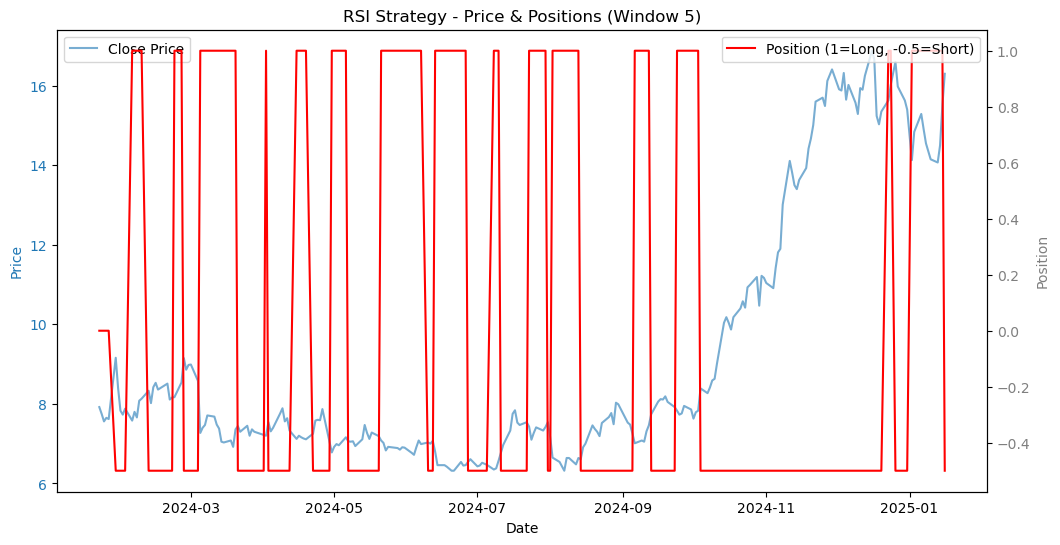

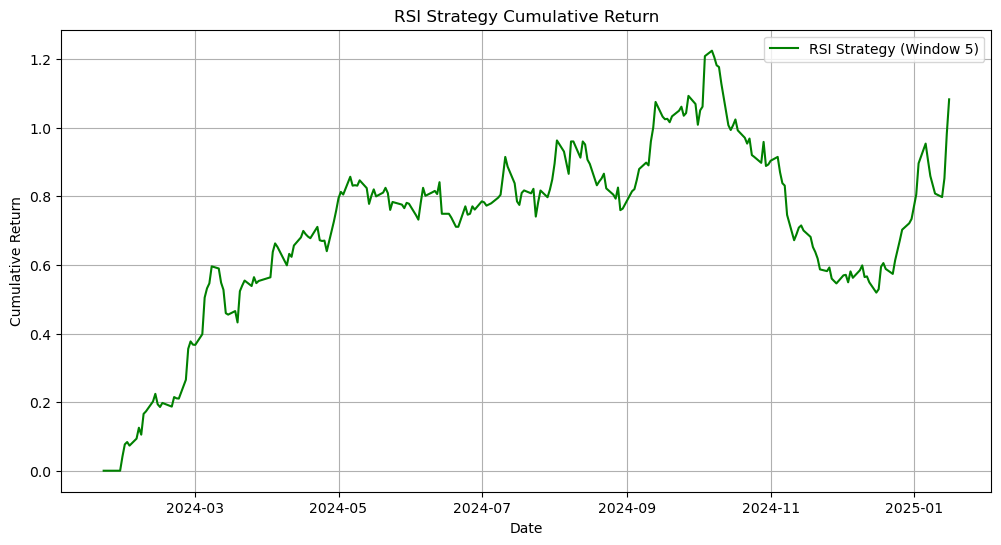

RSI Window	Total Return
5		108.28%
10		58.40%
15		-7.66%
20		-29.87%
25		2.24%
30		-23.40%
35		-21.84%
40		-20.48%
45		-23.40%
50		-21.84%

Best RSI window for SOFI: 5 with Total Return: 108.28%


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Function to compute RSI for a given series and window
def compute_RSI(series, window):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=window, min_periods=window).mean()
    avg_loss = loss.rolling(window=window, min_periods=window).mean()
    RS = avg_gain / (avg_loss + 1e-10)  # Avoid division by zero
    RSI = 100 - (100 / (1 + RS))
    return RSI

# Function to build the RSI strategy with long and short positions
def rsi_strategy(df, window, oversold=30, overbought=80):
    df = df.copy()
    df['RSI'] = compute_RSI(df['Close'], window)

    # Generate trading signals: +1 for long, -0.5 for short
    df['Signal'] = 0
    df.loc[df['RSI'] < oversold, 'Signal'] = 1  # Long
    df.loc[df['RSI'] > overbought, 'Signal'] = -0.5  # Short (Modified from -1 to -0.5)

    # Carry forward the last signal until a new signal appears
    df['Position'] = df['Signal'].replace(to_replace=0, method='ffill').fillna(0)

    # Calculate daily returns and strategy returns
    df['Returns'] = df['Close'].pct_change()
    df['Strategy_Returns'] = df['Position'].shift(1) * df['Returns']
    df['Strategy_Returns'].fillna(0, inplace=True)

    # Compute cumulative returns
    df['Cumulative_Return'] = (1 + df['Strategy_Returns']).cumprod() - 1
    total_return = df['Cumulative_Return'].iloc[-1]

    return total_return, df

# Function to plot strategy results, including price, position, and cumulative returns
def plot_rsi_strategy(df, best_window):
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot actual price
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price', color='tab:blue')
    ax1.plot(df.index, df['Close'], label='Close Price', color='tab:blue', alpha=0.6)
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Plot position (Long/Short) on secondary axis
    ax2 = ax1.twinx()
    ax2.set_ylabel('Position', color='tab:gray')
    ax2.plot(df.index, df['Position'], label='Position (1=Long, -0.5=Short)', color='red')
    ax2.tick_params(axis='y', labelcolor='tab:gray')

    # Add legends
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    plt.title(f'RSI Strategy - Price & Positions (Window {best_window})')
    plt.show()

    # Plot cumulative returns separately
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['Cumulative_Return'], label=f'RSI Strategy (Window {best_window})', color='green')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.title('RSI Strategy Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to perform grid search over RSI windows
def find_best_rsi_window(df, window_range):
    results = {}
    for window in window_range:
        total_return, _ = rsi_strategy(df, window)
        results[window] = total_return
    best_window = max(results, key=results.get)
    _, best_strategy_df = rsi_strategy(df, best_window)
    return best_window, results, best_strategy_df

# Example usage (make sure 'sofi' DataFrame with 'Close' and datetime index is already defined)
window_range = range(5, 51, 5)
best_window, results, best_strategy_df = find_best_rsi_window(sofi, window_range)
plot_rsi_strategy(best_strategy_df, best_window)

# Print the best RSI window and corresponding return
print("RSI Window\tTotal Return")
for w, ret in results.items():
    print(f"{w}\t\t{ret:.2%}")
print(f"\nBest RSI window for SOFI: {best_window} with Total Return: {results[best_window]:.2%}")



SMA Strategy

C:\Users\ASUS\AppData\Local\Temp\ipykernel_27220\400915506.py:20: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Returns'] = df['Close'].pct_change().fillna(0)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27220\400915506.py:20: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Returns'] = df['Close'].pct_change().fillna(0)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27220\400915506.py:20: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_met

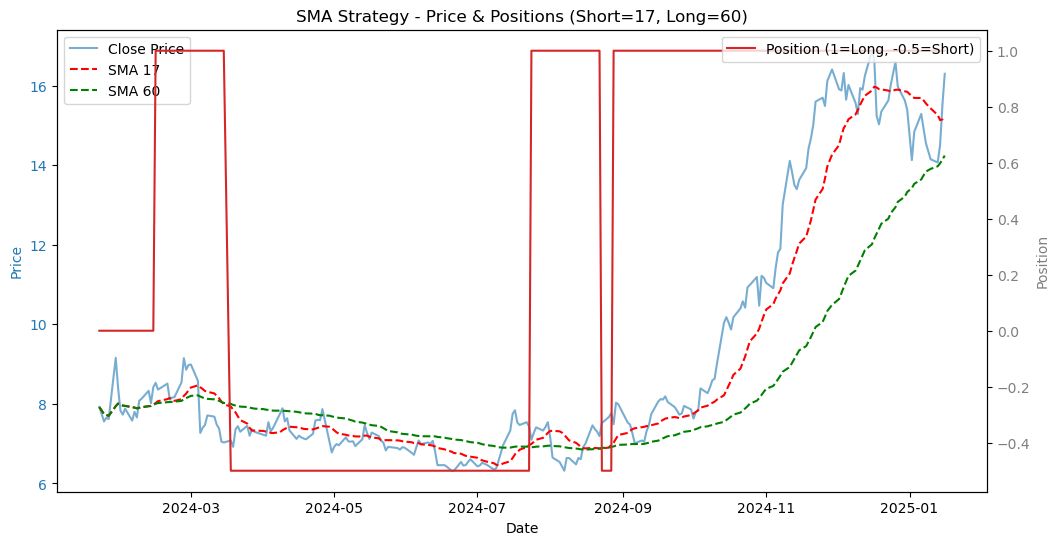

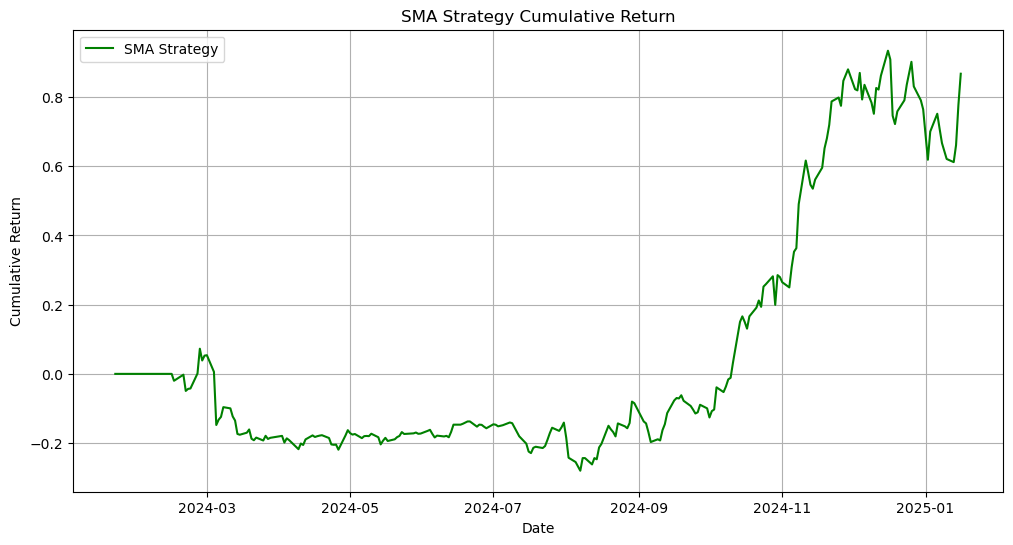

Short SMA	Long SMA	Total Return
5		30		-6.20%
5		35		3.99%
5		40		5.88%
5		45		2.11%
5		50		17.08%
5		55		39.93%
5		60		39.93%
5		65		39.93%
5		70		39.93%
5		75		39.93%
5		80		41.94%
5		85		41.94%
5		90		41.94%
5		95		54.64%
5		100		54.64%
7		30		9.61%
7		35		39.25%
7		40		39.85%
7		45		27.05%
7		50		32.97%
7		55		58.92%
7		60		68.73%
7		65		68.73%
7		70		68.73%
7		75		68.73%
7		80		72.60%
7		85		60.13%
7		90		60.13%
7		95		62.05%
7		100		62.05%
9		30		27.64%
9		35		19.48%
9		40		21.21%
9		45		36.60%
9		50		58.44%
9		55		70.86%
9		60		77.19%
9		65		79.32%
9		70		79.32%
9		75		79.32%
9		80		79.32%
9		85		67.52%
9		90		65.19%
9		95		60.34%
9		100		60.34%
11		30		13.72%
11		35		15.42%
11		40		14.84%
11		45		23.82%
11		50		49.76%
11		55		49.76%
11		60		49.76%
11		65		49.76%
11		70		42.34%
11		75		42.34%
11		80		42.34%
11		85		46.46%
11		90		46.46%
11		95		46.46%
11		100		53.65%
13		30		-3.82%
13		35		-9.96%
13		40		13.89%
13		45		36.32%
13		50		47.00%
13		55		44.96%
13		60		35.52%
13		65		

In [ ]:
# Function to calculate SMA (Simple Moving Average)
def calculate_sma(df, short_window, long_window):
    df['SMA_Short'] = df['Close'].rolling(window=short_window, min_periods=1).mean()
    df['SMA_Long'] = df['Close'].rolling(window=long_window, min_periods=1).mean()
    return df

# Function to implement SMA strategy and compute returns
def sma_strategy(df, short_window, long_window):
    df = calculate_sma(df, short_window, long_window)
    
    # Set positions based on SMA crossover signals
    df['Position'] = 0.0
    df.loc[df['SMA_Short'] > df['SMA_Long'], 'Position'] = 1.0  # Buy signal
    df.loc[df['SMA_Short'] < df['SMA_Long'], 'Position'] = -0.5  # Short signal (modified from -1 to -0.5)
    
    # Shift positions to avoid lookahead bias
    df['Position'] = df['Position'].shift(1, fill_value=0.0)

    # Calculate daily returns
    df['Returns'] = df['Close'].pct_change().fillna(0)

    # Compute strategy returns
    df['StrategyReturns'] = df['Position'].shift(1) * df['Returns']
    df['StrategyReturns'] = df['StrategyReturns'].fillna(0)

    # Compute cumulative returns
    df['CumulativeReturns'] = (1 + df['StrategyReturns']).cumprod() - 1

    total_return = df['CumulativeReturns'].iloc[-1]
    
    return total_return, df

# Function to plot SMA strategy results
def plot_sma_strategy(df, best_params):
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot actual price and moving averages
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price', color='tab:blue')
    ax1.plot(df.index, df['Close'], label='Close Price', color='tab:blue', alpha=0.6)
    ax1.plot(df.index, df['SMA_Short'], label=f'SMA {best_params[0]}', color='red', linestyle='dashed')
    ax1.plot(df.index, df['SMA_Long'], label=f'SMA {best_params[1]}', color='green', linestyle='dashed')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Plot position (Long/Short) on secondary axis
    ax2 = ax1.twinx()
    ax2.set_ylabel('Position', color='tab:gray')
    ax2.plot(df.index, df['Position'], label='Position (1=Long, -0.5=Short)', color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:gray')

    # Add legends
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    plt.title(f'SMA Strategy - Price & Positions (Short={best_params[0]}, Long={best_params[1]})')
    plt.show()

    # Plot cumulative returns separately
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['CumulativeReturns'], label='SMA Strategy', color='green')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.title('SMA Strategy Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.show() 

def sma_grid_search(df, short_windows=range(5, 21, 2), long_windows=range(30, 101, 5)):
    best_params = None
    best_return = -np.inf
    results = {}

    for short in short_windows:
        for long in long_windows:
            if short >= long:
                continue  # Skip invalid cases where short SMA >= long SMA
            total_return, _ = sma_strategy(df, short, long)
            results[(short, long)] = total_return

            if total_return > best_return:
                best_return = total_return
                best_params = (short, long)

    return best_params, best_return, results 

best_sma_params, best_sma_return, sma_results = sma_grid_search(sofi) 
_, best_sma_df = sma_strategy(sofi, *best_sma_params) 
# Plot the strategy results using the existing function
plot_sma_strategy(best_sma_df, best_sma_params)

# Print the best SMA parameters and corresponding return
print("Short SMA\tLong SMA\tTotal Return")
for params, ret in sma_results.items():
    print(f"{params[0]}\t\t{params[1]}\t\t{ret:.2%}")
print(f"\nBest SMA parameters for SOFI: Short={best_sma_params[0]}, Long={best_sma_params[1]} with Total Return: {best_sma_return:.2%}")

Linear Regression Strategy

In [2]:
def merge_data(df1, ticker="SOFI", start_date="2022-01-01", end_date="2024-01-16"):
    df1 = data[['Close', 'High', 'Low', 'Open', 'Volume']].copy()
    
    start_date = '2022-01-01'
    end_date = '2024-01-21'
    df2 = yf.download(ticker, start=start_date, end=end_date)

    # Make sure data is sorted by date
    df2.sort_index(inplace=True)
    df2 = df2.droplevel(1, axis=1)
    df = pd.concat((df2, df1)) 
    return df

def calculate_indicators(df):
    df = df.copy()
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')

    # Relative Strength Index (RSI)
    window = 14
    delta = df['Close'].diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(gain).rolling(window=window, min_periods=1).mean()
    avg_loss = pd.Series(loss).rolling(window=window, min_periods=1).mean()    
    rs = avg_gain / (avg_loss + 1e-10)
    df['RSI'] = 100 - (100 / (1 + rs))

    # Stochastic KDJ Indicator
    low_min = df['Low'].rolling(window=14, min_periods=1).min()
    high_max = df['High'].rolling(window=14, min_periods=1).max()
    df['KDJ_K'] = 100 * (df['Close'] - low_min) / (high_max - low_min + 1e-10)
    df['KDJ_D'] = df['KDJ_K'].rolling(window=3, min_periods=1).mean()

    # Moving Averages
    df['SMA_Short'] = df['Close'].rolling(window=7, min_periods=1).mean()
    df['SMA_Long'] = df['Close'].rolling(window=14, min_periods=1).mean()
    df['EMA'] = df['Close'].ewm(span=14, adjust=False).mean()
    df['SMA_EMA_Ratio'] = df['SMA_Short'] / (df['EMA'] + 1e-10)

    # On Balance Volume (OBV)
    df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()

    # Aroon Up & Aroon Down
    df['Aroon_Up'] = df['High'].rolling(window=14, min_periods=1).apply(lambda x: np.argmax(x) / 14 * 100)
    df['Aroon_Down'] = df['Low'].rolling(window=14, min_periods=1).apply(lambda x: np.argmin(x) / 14 * 100)

    # Average Directional Index (ADX)
    df['High-Low'] = df['High'] - df['Low']
    df['High-Close'] = np.abs(df['High'] - df['Close'].shift(1))
    df['Low-Close'] = np.abs(df['Low'] - df['Close'].shift(1))
    df['TrueRange'] = df[['High-Low', 'High-Close', 'Low-Close']].max(axis=1)
    df['ATR'] = df['TrueRange'].rolling(window=14, min_periods=1).mean()
    df['ADX'] = 100 * (df['ATR'] / (df['Close'] + 1e-10))

    # Chaikin Oscillator
    money_flow_multiplier = ((df['Close'] - df['Low']) - (df['High'] - df['Close'])) / (df['High'] - df['Low'] + 1e-10)
    money_flow_volume = money_flow_multiplier * df['Volume']
    df['Chaikin'] = money_flow_volume.rolling(window=3, min_periods=1).sum()

    # Commodity Channel Index (CCI)
    typical_price = (df['High'] + df['Low'] + df['Close']) / 3
    sma_tp = typical_price.rolling(window=14, min_periods=1).mean()
    mean_deviation = (typical_price - sma_tp).abs().rolling(window=14, min_periods=1).mean()
    df['CCI'] = (typical_price - sma_tp) / (0.015 * mean_deviation + 1e-10)

    return df

def grid_search_feature_selection(df, feature_range=range(3, 13)):
    best_num_features = None
    best_return = -np.inf
    results = {}

    for num_features in feature_range:
        try:
            if num_features <= 0:
                continue

            total_return, _ = linear_regression_strategy(df, num_features)
            results[num_features] = total_return

            if total_return > best_return:
                best_return = total_return
                best_num_features = num_features

        except ValueError as e:
            print(f"⚠️ Skipping {num_features} features due to error: {e}")
            continue

    if best_num_features is None:
        raise ValueError("❌ Grid search failed: No valid feature configuration worked.")

    return best_num_features, best_return, results

def linear_regression_strategy(df, num_features,
                               train_start='2022-01-01',
                               train_end='2024-01-16',
                               test_start='2024-03-01',
                               test_end='2025-01-16'):
    """
    Performs linear regression using data until 16 January 2024 as training data,
    and uses only trading data from 1 March 2024 to 16 January 2025 as test data.
    
    Trading Logic:
      - Long (1.0) if the predicted next-day Close is higher than today's Close.
      - Short (-0.5) if the predicted next-day Close is lower than today's Close.
    
    Returns:
      total_return (float): Total return over the test period.
      df (pd.DataFrame): DataFrame with predictions, positions, and performance metrics.
    """
    # Merge local and Yahoo data
    df = merge_data(df)
    
    if 'Date' not in df.columns and df.index.name == 'Date':
        df.reset_index(inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])
    
    print("\n🧪 Merged Date Range:", df['Date'].min(), "to", df['Date'].max())
    print("📏 Total Rows in Merged DF:", len(df))
    print("🧮 Unique Dates:", df['Date'].nunique())
    
    # Calculate technical indicators
    df = calculate_indicators(df)
    df.set_index('Date', inplace=True)
    df['Predicted_Close'] = np.nan

    # Define feature columns (including 'Close' for prediction)
    feature_columns = ['RSI', 'KDJ_K', 'KDJ_D', 'SMA_Short', 'SMA_Long', 'EMA',
                       'SMA_EMA_Ratio', 'OBV', 'Aroon_Up', 'Aroon_Down', 'ADX',
                       'Chaikin', 'CCI', 'Close']
    
    # Create features and target (target is next day's Close)
    X = df[feature_columns]
    y = df['Close'].shift(-1)
    X = X.iloc[:-1]
    y = y.dropna()
    df = df.iloc[:-1]

    train_start_date = pd.to_datetime(train_start)
    train_end_date = pd.to_datetime(train_end)
    test_start_date = pd.to_datetime(test_start)
    test_end_date = pd.to_datetime(test_end)
    
    X_train = X[(X.index >= train_start_date) & (X.index <= train_end_date)]
    y_train = y[(y.index >= train_start_date) & (y.index <= train_end_date)]
    X_test = X[(X.index >= test_start_date) & (X.index <= test_end_date)]
    
    print("✅ X_train shape:", X_train.shape)
    print("✅ X_test shape:", X_test.shape)

    if X_train.shape[0] == 0 or X_test.shape[0] == 0:
        raise ValueError("🚫 Training or testing data is empty. Check your date ranges or source data.")

    if num_features >= X_train.shape[1]:
        raise ValueError(f"❌ num_features={num_features} must be less than the number of available features={X_train.shape[1]}.")

    from sklearn.impute import SimpleImputer
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import LinearRegression
    from sklearn.feature_selection import SequentialFeatureSelector

    imputer = SimpleImputer(strategy='mean')
    scaler = StandardScaler()
    X_train_imputed = imputer.fit_transform(X_train)
    X_train_scaled = scaler.fit_transform(X_train_imputed)

    model = LinearRegression()
    sfs = SequentialFeatureSelector(model, n_features_to_select=num_features, direction='forward')
    X_train_selected = sfs.fit_transform(X_train_scaled, y_train)
    model.fit(X_train_selected, y_train)

    X_test_imputed = imputer.transform(X_test)
    X_test_scaled = scaler.transform(X_test_imputed)
    X_test_selected = sfs.transform(X_test_scaled)
    predictions = model.predict(X_test_selected)
    
    df.loc[X_test.index, 'Predicted_Close'] = predictions

    # Updated Trading Logic:
    # Long (1.0) if predicted next-day Close > today's Close, Short (-0.5) if predicted next-day Close < today's Close.
    df['Position'] = np.where(df['Predicted_Close'] > df['Predicted_Close'].shift(1), 1.0, -0.5)
    df['Position'] = df['Position'].shift(1, fill_value=0.0)

    # Benchmark Perfect Strategy for comparison (optional)
    df['PerfectPosition'] = 0.0
    df['NextReturn'] = df['Close'].shift(-1) / df['Close'] - 1
    df.loc[df['NextReturn'] > 0, 'PerfectPosition'] = 1.0
    df.loc[df['NextReturn'] <= 0, 'PerfectPosition'] = -0.5
    df['PerfectPosition'] = df['PerfectPosition'].shift(1, fill_value=0.0)

    df['Returns'] = df['Close'].pct_change().fillna(0)
    df['StrategyReturns'] = df['Position'] * df['Returns']
    df['PerfectReturns'] = df['PerfectPosition'] * df['Returns']
    df['BuyHoldReturns'] = (1 + df['Returns']).cumprod() - 1
    df['CumulativeReturns'] = (1 + df['StrategyReturns']).cumprod() - 1
    df['PerfectCumulativeReturns'] = (1 + df['PerfectReturns']).cumprod() - 1

    if not df.index.is_monotonic_increasing:
        df.sort_index(inplace=True)
        
    test_period_returns = df.loc[(df.index >= test_start_date) & (df.index <= test_end_date), 'CumulativeReturns']
    total_return = test_period_returns.iloc[-1] if not test_period_returns.empty else np.nan

    return total_return, df

def plot_trading_strategy(df, test_start='2024-03-01', test_end='2025-01-16'):
    """
    Plots two charts for the test (trading) period:
      1. Actual Price, Predicted Price, and Position.
      2. Buy & Hold Return vs. Strategy Return.
    
    Parameters:
      df (pd.DataFrame): DataFrame containing the trading strategy results.
      test_start (str): Start date for the trading period.
      test_end (str): End date for the trading period.
    """
    # Ensure the DataFrame index is datetime and filter for the trading period
    if not isinstance(df.index, pd.DatetimeIndex):
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)
    
    test_start_date = pd.to_datetime(test_start)
    test_end_date = pd.to_datetime(test_end)
    trading_df = df[(df.index >= test_start_date) & (df.index <= test_end_date)]
    
    if trading_df.empty:
        raise ValueError("No data in the specified trading period.")
    
    # --- Chart 1: Price, Predicted Price, and Position ---
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.plot(trading_df.index, trading_df['Close'], label='Actual Price', color='blue', alpha=0.8)
    ax1.plot(trading_df.index, trading_df['Predicted_Close'], label='Predicted Price', color='red', linestyle='--', alpha=0.8)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.legend(loc='upper left')
    
    ax2 = ax1.twinx()
    ax2.plot(trading_df.index, trading_df['Position'], label='Position', color='green', alpha=0.8)
    ax2.set_ylabel('Position', color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    ax2.legend(loc='upper right')
    
    plt.title('Trading Strategy: Actual Price, Predicted Price, and Position')
    plt.show()
    
    # --- Chart 2: Buy & Hold vs. Strategy Returns ---
    plt.figure(figsize=(12, 6))
    plt.plot(trading_df.index, trading_df['BuyHoldReturns'], label='Buy & Hold Return', linestyle='--', color='gray', alpha=0.8)
    plt.plot(trading_df.index, trading_df['CumulativeReturns'], label='Strategy Return', color='green', alpha=0.8)
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.title('Buy & Hold Return vs. Trading Strategy Return')
    plt.legend()
    plt.grid(True)
    plt.show()



# Evaluation and summary outputs remain unchanged.
def evaluate_regression_performance(df):
    y_true = df['Close'].shift(-1).dropna()
    y_pred = df['Predicted_Close'].dropna()
    y_pred = y_pred.loc[y_true.index.intersection(y_pred.index)]
    y_true = y_true.loc[y_pred.index]
    if len(y_true) == 0:
        print("⚠ No valid predictions to evaluate.")
        return
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    actual_direction = np.sign(y_true.diff())
    predicted_direction = np.sign(y_pred.diff())
    correct_direction = (actual_direction == predicted_direction).sum()
    accuracy = correct_direction / len(actual_direction.dropna()) * 100
    print("\nEvaluation Metrics:")
    print(f"Mean Squared Error (MSE):  {mse:.4f}")
    print(f"Root Mean Squared Error:   {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R² Score:                  {r2:.4f}")
    print(f"Directional Accuracy:      {accuracy:.2f}%") 

# Run grid search for best number of features
best_features, best_return, feature_results = grid_search_feature_selection(sofi)
# Apply the best feature selection strategy and run the linear regression strategy
total_return, best_feature_df = linear_regression_strategy(sofi, best_features)
# Plot only the trading period's actual closing prices
plot_trading_strategy(best_feature_df, test_start='2024-03-01', test_end='2025-01-16')

evaluate_regression_performance(best_feature_df)

print("\nFeature Count\tTotal Return")
for num_features, ret in feature_results.items():
    print(f"{num_features}\t\t{ret:.2%}")

print(f"\nBest number of features: {best_features} with Total Return: {best_return:.2%}")

print("Summary")
strategy_return = best_feature_df['CumulativeReturns'].iloc[-1]
buyhold_return = best_feature_df['BuyHoldReturns'].iloc[-1]
perfect_return = best_feature_df['PerfectCumulativeReturns'].iloc[-1]  
print(f"Buy & Hold Return: {buyhold_return:.2%}")
print(f"Linear Regression Strategy Return: {strategy_return:.2%}")
print(f"Perfect Strategy Return: {perfect_return:.2%}")


NameError: name 'sofi' is not defined

[*********************100%***********************]  1 of 1 completed



🧪 Merged Date Range: 2022-01-03 00:00:00 to 2025-01-16 00:00:00
📏 Total Rows in Merged DF: 761
🧮 Unique Dates: 759
✅ X_train shape: (510, 14)
✅ X_test shape: (221, 14)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_22328\4048355762.py:248: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Returns'] = df['Close'].pct_change().fillna(0)
[*********************100%***********************]  1 of 1 completed



🧪 Merged Date Range: 2022-01-03 00:00:00 to 2025-01-16 00:00:00
📏 Total Rows in Merged DF: 761
🧮 Unique Dates: 759
✅ X_train shape: (510, 14)
✅ X_test shape: (221, 14)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_22328\4048355762.py:248: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Returns'] = df['Close'].pct_change().fillna(0)
[*********************100%***********************]  1 of 1 completed



🧪 Merged Date Range: 2022-01-03 00:00:00 to 2025-01-16 00:00:00
📏 Total Rows in Merged DF: 761
🧮 Unique Dates: 759
✅ X_train shape: (510, 14)
✅ X_test shape: (221, 14)


c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ASUS\AppData\Local\Temp\ipykernel_22328\4048355762.py:248: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Returns'] = df['Close'].pct_change().fillna(0)
[*********************100%***********************]  1 of 1 completed



🧪 Merged Date Range: 2022-01-03 00:00:00 to 2025-01-16 00:00:00
📏 Total Rows in Merged DF: 761
🧮 Unique Dates: 759
✅ X_train shape: (510, 14)
✅ X_test shape: (221, 14)


c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ASUS\AppData\Local\Temp\ipykernel_22328\4048355762.py:248: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Returns'] = df['Close'].pct_change().fillna(0)
[*********************100%***********************]  1 of 1 completed



🧪 Merged Date Range: 2022-01-03 00:00:00 to 2025-01-16 00:00:00
📏 Total Rows in Merged DF: 761
🧮 Unique Dates: 759
✅ X_train shape: (510, 14)
✅ X_test shape: (221, 14)


c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ASUS\AppData\Local\Temp\ipykernel_22328\4048355762.py:248: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Returns'] = df['Close'].pct_change().fillna(0)
[*********************100%***********************]  1 of 1 completed



🧪 Merged Date Range: 2022-01-03 00:00:00 to 2025-01-16 00:00:00
📏 Total Rows in Merged DF: 761
🧮 Unique Dates: 759
✅ X_train shape: (510, 14)
✅ X_test shape: (221, 14)


c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ASUS\AppData\Local\Temp\ipykernel_22328\4048355762.py:248: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Returns'] = df['Close'].pct_change().fillna(0)
[*********************100%***********************]  1 of 1 completed



🧪 Merged Date Range: 2022-01-03 00:00:00 to 2025-01-16 00:00:00
📏 Total Rows in Merged DF: 761
🧮 Unique Dates: 759
✅ X_train shape: (510, 14)
✅ X_test shape: (221, 14)


c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ASUS\AppData\Local\Temp\ipykernel_22328\4048355762.py:248: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Returns'] = df['Close'].pct_change().fillna(0)
[*********************100%***********************]  1 of 1 completed



🧪 Merged Date Range: 2022-01-03 00:00:00 to 2025-01-16 00:00:00
📏 Total Rows in Merged DF: 761
🧮 Unique Dates: 759
✅ X_train shape: (510, 14)
✅ X_test shape: (221, 14)


c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ASUS\AppData\Local\Temp\ipykernel_22328\4048355762.py:248: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Returns'] = df['Close'].pct_change().fillna(0)
[*********************100%***********************]  1 of 1 completed



🧪 Merged Date Range: 2022-01-03 00:00:00 to 2025-01-16 00:00:00
📏 Total Rows in Merged DF: 761
🧮 Unique Dates: 759
✅ X_train shape: (510, 14)
✅ X_test shape: (221, 14)


c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ASUS\AppData\Local\Temp\ipykernel_22328\4048355762.py:248: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Returns'] = df['Close'].pct_change().fillna(0)
[*********************100%***********************]  1 of 1 completed



🧪 Merged Date Range: 2022-01-03 00:00:00 to 2025-01-16 00:00:00
📏 Total Rows in Merged DF: 761
🧮 Unique Dates: 759
✅ X_train shape: (510, 14)
✅ X_test shape: (221, 14)


c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ASUS\AppData\Local\Temp\ipykernel_22328\4048355762.py:248: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Returns'] = df['Close'].pct_change().fillna(0)
[*********************100%***********************]  1 of 1 completed



🧪 Merged Date Range: 2022-01-03 00:00:00 to 2025-01-16 00:00:00
📏 Total Rows in Merged DF: 761
🧮 Unique Dates: 759
✅ X_train shape: (510, 14)
✅ X_test shape: (221, 14)


c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ASUS\AppData\Local\Temp\ipykernel_22328\4048355762.py:248: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Returns'] = df['Close'].pct_change().fillna(0)


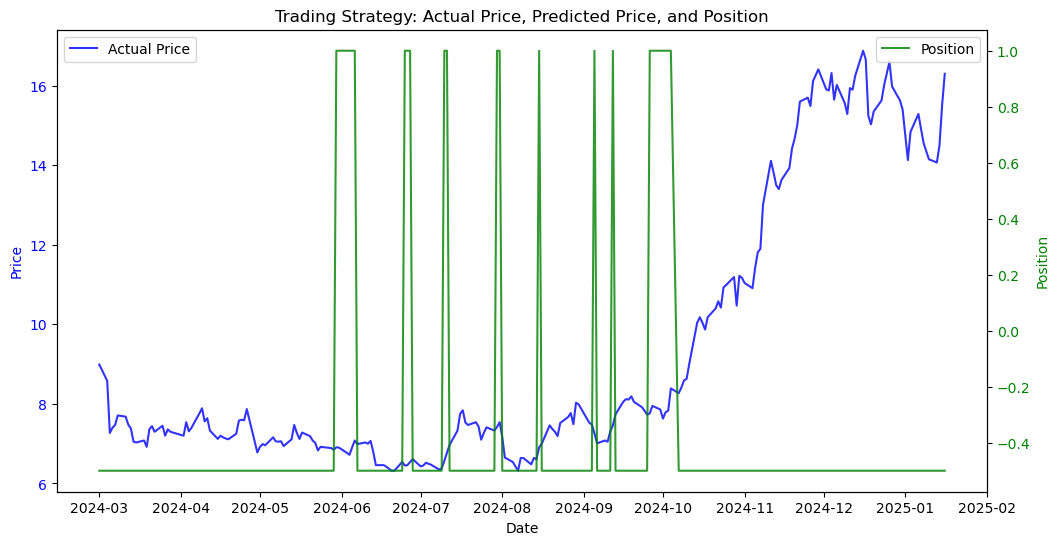

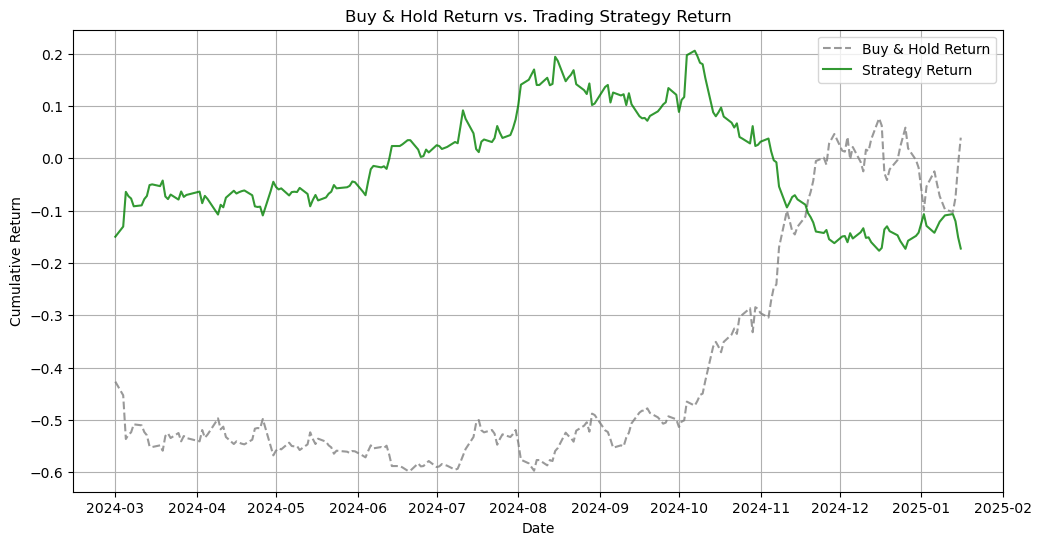

NameError: name 'y_true' is not defined

In [5]:
def merge_data(local_df, ticker="SOFI", start_date="2022-01-01", end_date="2024-01-16"):
    """
    Merges local stock data (with Date as index or column) with Yahoo Finance data and returns
    a single DataFrame with one set of columns:
    Date, Open, High, Low, Close, Volume, Stock Splits, Dividends.
    
    Local data is treated as primary, and missing values are filled from Yahoo data.
    """
    # Define the expected columns (excluding Date)
    expected_cols = ["Open", "High", "Low", "Close", "Volume", "Stock Splits", "Dividends"]
    desired_cols = ["Date"] + expected_cols

    # --- Process local_df ---
    if local_df.index.name != "Date":
        local_df = local_df.reset_index()
        if "Date" not in local_df.columns:
            local_df = local_df.rename(columns={local_df.columns[0]: "Date"})
    else:
        local_df = local_df.reset_index()
    
    local_df.columns = local_df.columns.str.strip().str.title()
    if "Date" not in local_df.columns:
        raise KeyError("Local DataFrame does not contain a 'Date' column after processing.")
    local_df["Date"] = pd.to_datetime(local_df["Date"])
    local_existing = [col for col in desired_cols if col in local_df.columns]
    local_df = local_df[local_existing]
    
    # --- Process Yahoo Finance data ---
    yf_df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)
    yf_df.reset_index(inplace=True)
    if isinstance(yf_df.columns, pd.MultiIndex):
        yf_df.columns = yf_df.columns.get_level_values(0)
    yf_df.columns = yf_df.columns.str.strip().str.title()
    if "Date" not in yf_df.columns:
        raise KeyError("Yahoo Finance DataFrame does not contain a 'Date' column.")
    yf_df["Date"] = pd.to_datetime(yf_df["Date"])
    for col in expected_cols:
        if col not in yf_df.columns and col in ["Dividends", "Stock Splits"]:
            yf_df[col] = 0.0
    yf_existing = [col for col in desired_cols if col in yf_df.columns]
    yf_df = yf_df[yf_existing]
    
    # --- Merge the two DataFrames ---
    local_df = local_df.set_index("Date")
    yf_df = yf_df.set_index("Date")
    combined = local_df.combine_first(yf_df)
    combined = combined.sort_index().reset_index()
    final_cols = [col for col in desired_cols if col in combined.columns]
    combined = combined[final_cols]
    
    return combined

def calculate_indicators(df):
    df = df.copy()
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')

    # Relative Strength Index (RSI)
    window = 14
    delta = df['Close'].diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(gain).rolling(window=window, min_periods=1).mean()
    avg_loss = pd.Series(loss).rolling(window=window, min_periods=1).mean()    
    rs = avg_gain / (avg_loss + 1e-10)
    df['RSI'] = 100 - (100 / (1 + rs))

    # Stochastic KDJ Indicator
    low_min = df['Low'].rolling(window=14, min_periods=1).min()
    high_max = df['High'].rolling(window=14, min_periods=1).max()
    df['KDJ_K'] = 100 * (df['Close'] - low_min) / (high_max - low_min + 1e-10)
    df['KDJ_D'] = df['KDJ_K'].rolling(window=3, min_periods=1).mean()

    # Moving Averages
    df['SMA_Short'] = df['Close'].rolling(window=7, min_periods=1).mean()
    df['SMA_Long'] = df['Close'].rolling(window=14, min_periods=1).mean()
    df['EMA'] = df['Close'].ewm(span=14, adjust=False).mean()
    df['SMA_EMA_Ratio'] = df['SMA_Short'] / (df['EMA'] + 1e-10)

    # On Balance Volume (OBV)
    df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()

    # Aroon Up & Aroon Down
    df['Aroon_Up'] = df['High'].rolling(window=14, min_periods=1).apply(lambda x: np.argmax(x) / 14 * 100)
    df['Aroon_Down'] = df['Low'].rolling(window=14, min_periods=1).apply(lambda x: np.argmin(x) / 14 * 100)

    # Average Directional Index (ADX)
    df['High-Low'] = df['High'] - df['Low']
    df['High-Close'] = np.abs(df['High'] - df['Close'].shift(1))
    df['Low-Close'] = np.abs(df['Low'] - df['Close'].shift(1))
    df['TrueRange'] = df[['High-Low', 'High-Close', 'Low-Close']].max(axis=1)
    df['ATR'] = df['TrueRange'].rolling(window=14, min_periods=1).mean()
    df['ADX'] = 100 * (df['ATR'] / (df['Close'] + 1e-10))

    # Chaikin Oscillator
    money_flow_multiplier = ((df['Close'] - df['Low']) - (df['High'] - df['Close'])) / (df['High'] - df['Low'] + 1e-10)
    money_flow_volume = money_flow_multiplier * df['Volume']
    df['Chaikin'] = money_flow_volume.rolling(window=3, min_periods=1).sum()

    # Commodity Channel Index (CCI)
    typical_price = (df['High'] + df['Low'] + df['Close']) / 3
    sma_tp = typical_price.rolling(window=14, min_periods=1).mean()
    mean_deviation = (typical_price - sma_tp).abs().rolling(window=14, min_periods=1).mean()
    df['CCI'] = (typical_price - sma_tp) / (0.015 * mean_deviation + 1e-10)

    return df

def grid_search_feature_selection(df, feature_range=range(3, 13)):
    best_num_features = None
    best_return = -np.inf
    results = {}

    for num_features in feature_range:
        try:
            if num_features <= 0:
                continue

            total_return, _ = mlp_classifier_strategy(df, num_features)
            results[num_features] = total_return

            if total_return > best_return:
                best_return = total_return
                best_num_features = num_features

        except ValueError as e:
            print(f"⚠️ Skipping {num_features} features due to error: {e}")
            continue

    if best_num_features is None:
        raise ValueError("❌ Grid search failed: No valid feature configuration worked.")

    return best_num_features, best_return, results

def mlp_classifier_strategy(df, num_features,
                            train_start='2022-01-01',
                            train_end='2024-01-16',
                            test_start='2024-03-01',
                            test_end='2025-01-16'):
    """
    Performs classification using an MLP deep neural network classifier.
    
    Uses data until 16 January 2024 as training data and only uses trading data 
    from 1 March 2024 to 16 January 2025 as test data.
    
    Target definition:
      - 1 if tomorrow's Close > today's Close,
      - 0 otherwise.
    
    Trading Logic:
      - Long (1.0) if predicted signal == 1,
      - Short (-0.5) if predicted signal == 0.
    
    Returns:
      total_return (float): Total return over the test period.
      df (pd.DataFrame): DataFrame with predictions, positions, and performance metrics.
    """
    # Merge local and Yahoo Finance data
    df = merge_data(df)
    
    if 'Date' not in df.columns and df.index.name == 'Date':
        df.reset_index(inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])
    
    print("\n🧪 Merged Date Range:", df['Date'].min(), "to", df['Date'].max())
    print("📏 Total Rows in Merged DF:", len(df))
    print("🧮 Unique Dates:", df['Date'].nunique())
    
    # Calculate technical indicators
    df = calculate_indicators(df)
    df.set_index('Date', inplace=True)
    
    # Create binary target: 1 if next day's Close > today's Close, else 0.
    df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)
    df = df.iloc[:-1]  # Drop last row (target is NaN)
    
    # Define feature columns (including 'Close' for prediction)
    feature_columns = ['RSI', 'KDJ_K', 'KDJ_D', 'SMA_Short', 'SMA_Long', 'EMA',
                       'SMA_EMA_Ratio', 'OBV', 'Aroon_Up', 'Aroon_Down', 'ADX',
                       'Chaikin', 'CCI', 'Close']
    
    X = df[feature_columns]
    y = df['Target']
    
    # Define training and test date ranges
    train_start_date = pd.to_datetime(train_start)
    train_end_date = pd.to_datetime(train_end)
    test_start_date = pd.to_datetime(test_start)
    test_end_date = pd.to_datetime(test_end)
    
    X_train = X[(X.index >= train_start_date) & (X.index <= train_end_date)]
    y_train = y[(y.index >= train_start_date) & (y.index <= train_end_date)]
    X_test = X[(X.index >= test_start_date) & (X.index <= test_end_date)]
    
    print("✅ X_train shape:", X_train.shape)
    print("✅ X_test shape:", X_test.shape)
    
    if X_train.shape[0] == 0 or X_test.shape[0] == 0:
        raise ValueError("🚫 Training or testing data is empty. Check your date ranges or source data.")
    
    if num_features >= X_train.shape[1]:
        raise ValueError(f"❌ num_features={num_features} must be less than the number of available features={X_train.shape[1]}.")

    from sklearn.impute import SimpleImputer
    from sklearn.preprocessing import StandardScaler
    from sklearn.neural_network import MLPClassifier
    from sklearn.feature_selection import SequentialFeatureSelector

    # Impute and scale training data
    imputer = SimpleImputer(strategy='mean')
    scaler = StandardScaler()
    
    X_train_imputed = imputer.fit_transform(X_train)
    X_train_scaled = scaler.fit_transform(X_train_imputed)
    
    # Initialize MLPClassifier; adjust hidden_layer_sizes as needed.
    clf = MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000, random_state=42)
    
    # Use sequential feature selection to choose num_features features
    sfs = SequentialFeatureSelector(clf, n_features_to_select=num_features, direction='forward')
    X_train_selected = sfs.fit_transform(X_train_scaled, y_train)
    
    # Train the MLP classifier
    clf.fit(X_train_selected, y_train)
    
    # Process test data similarly
    X_test_imputed = imputer.transform(X_test)
    X_test_scaled = scaler.transform(X_test_imputed)
    X_test_selected = sfs.transform(X_test_scaled)
    
    # Get predicted signals (0 or 1)
    predictions = clf.predict(X_test_selected)
    
    # Store predicted signal in DataFrame for test dates
    df.loc[X_test.index, 'Predicted_Signal'] = predictions
    
    # Trading Logic:
    # Long (1.0) if predicted signal == 1, Short (-0.5) if predicted signal == 0.
    df['Position'] = np.where(df['Predicted_Signal'] == 1, 1.0, -0.5)
    df['Position'] = df['Position'].shift(1, fill_value=0.0)
    
    # Benchmark Perfect Strategy for comparison (optional)
    df['PerfectPosition'] = 0.0
    df['NextReturn'] = df['Close'].shift(-1) / df['Close'] - 1
    df.loc[df['NextReturn'] > 0, 'PerfectPosition'] = 1.0
    df.loc[df['NextReturn'] <= 0, 'PerfectPosition'] = -0.5
    df['PerfectPosition'] = df['PerfectPosition'].shift(1, fill_value=0.0)
    
    # Compute returns
    df['Returns'] = df['Close'].pct_change().fillna(0)
    df['StrategyReturns'] = df['Position'] * df['Returns']
    df['PerfectReturns'] = df['PerfectPosition'] * df['Returns']
    df['BuyHoldReturns'] = (1 + df['Returns']).cumprod() - 1
    df['CumulativeReturns'] = (1 + df['StrategyReturns']).cumprod() - 1
    df['PerfectCumulativeReturns'] = (1 + df['PerfectReturns']).cumprod() - 1
    
    if not df.index.is_monotonic_increasing:
        df.sort_index(inplace=True)
    
    test_period_returns = df.loc[(df.index >= test_start_date) & (df.index <= test_end_date), 'CumulativeReturns']
    total_return = test_period_returns.iloc[-1] if not test_period_returns.empty else np.nan
    
    return total_return, df


def plot_trading_strategy(df, test_start='2024-03-01', test_end='2025-01-16'):
    """
    Plots two charts for the trading period:
      1. Actual Price, Predicted Price, and Position.
      2. Buy & Hold Return vs. Strategy Return.
    
    Parameters:
      df (pd.DataFrame): DataFrame with trading strategy results.
      test_start (str): Start date for the trading period.
      test_end (str): End date for the trading period.
    """
    # Ensure the index is a datetime index
    if not isinstance(df.index, pd.DatetimeIndex):
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)
    
    test_start_date = pd.to_datetime(test_start)
    test_end_date = pd.to_datetime(test_end)
    trading_df = df[(df.index >= test_start_date) & (df.index <= test_end_date)]
    
    if trading_df.empty:
        raise ValueError("No data in the specified trading period.")
    
    # --- Chart 1: Actual Price, Predicted Price, and Position ---
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.plot(trading_df.index, trading_df['Close'], label='Actual Price', color='blue', alpha=0.8)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.legend(loc='upper left')
    
    ax2 = ax1.twinx()
    ax2.plot(trading_df.index, trading_df['Position'], label='Position', color='green', alpha=0.8)
    ax2.set_ylabel('Position', color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    ax2.legend(loc='upper right')
    
    plt.title('Trading Strategy: Actual Price, Predicted Price, and Position')
    plt.show()
    
    # --- Chart 2: Buy & Hold vs. Strategy Returns ---
    plt.figure(figsize=(12, 6))
    plt.plot(trading_df.index, trading_df['BuyHoldReturns'], label='Buy & Hold Return', linestyle='--', color='gray', alpha=0.8)
    plt.plot(trading_df.index, trading_df['CumulativeReturns'], label='Strategy Return', color='green', alpha=0.8)
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.title('Buy & Hold Return vs. Trading Strategy Return')
    plt.legend()
    plt.grid(True)
    plt.show()


# Evaluation and summary outputs remain unchanged.
def evaluate_accuracy(df):
    actual_direction = np.sign(y_true.diff())
    predicted_direction = np.sign(y_pred.diff())
    correct_direction = (actual_direction == predicted_direction).sum()
    accuracy = correct_direction / len(actual_direction.dropna()) * 100
    print("\nEvaluation Metrics:")
    print(f"Mean Squared Error (MSE):  {mse:.4f}")
    print(f"Root Mean Squared Error:   {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R² Score:                  {r2:.4f}")
    print(f"Directional Accuracy:      {accuracy:.2f}%") 

# Run grid search for best number of features
best_features, best_return, feature_results = grid_search_feature_selection(sofi)
# Apply the best feature selection strategy and run the linear regression strategy
total_return, best_feature_df = mlp_classifier_strategy(sofi, best_features)
# Plot only the trading period's actual closing prices
plot_trading_strategy(best_feature_df, test_start='2024-03-01', test_end='2025-01-16')

evaluate_accuracy(best_feature_df)

print("\nFeature Count\tTotal Return")
for num_features, ret in feature_results.items():
    print(f"{num_features}\t\t{ret:.2%}")

print(f"\nBest number of features: {best_features} with Total Return: {best_return:.2%}")

print("Summary")
strategy_return = best_feature_df['CumulativeReturns'].iloc[-1]
buyhold_return = best_feature_df['BuyHoldReturns'].iloc[-1]
perfect_return = best_feature_df['PerfectCumulativeReturns'].iloc[-1]  
print(f"Buy & Hold Return: {buyhold_return:.2%}")
print(f"Linear Regression Strategy Return: {strategy_return:.2%}")
print(f"Perfect Strategy Return: {perfect_return:.2%}")


[*********************100%***********************]  1 of 1 completed


Cumulative Return: 38.4136


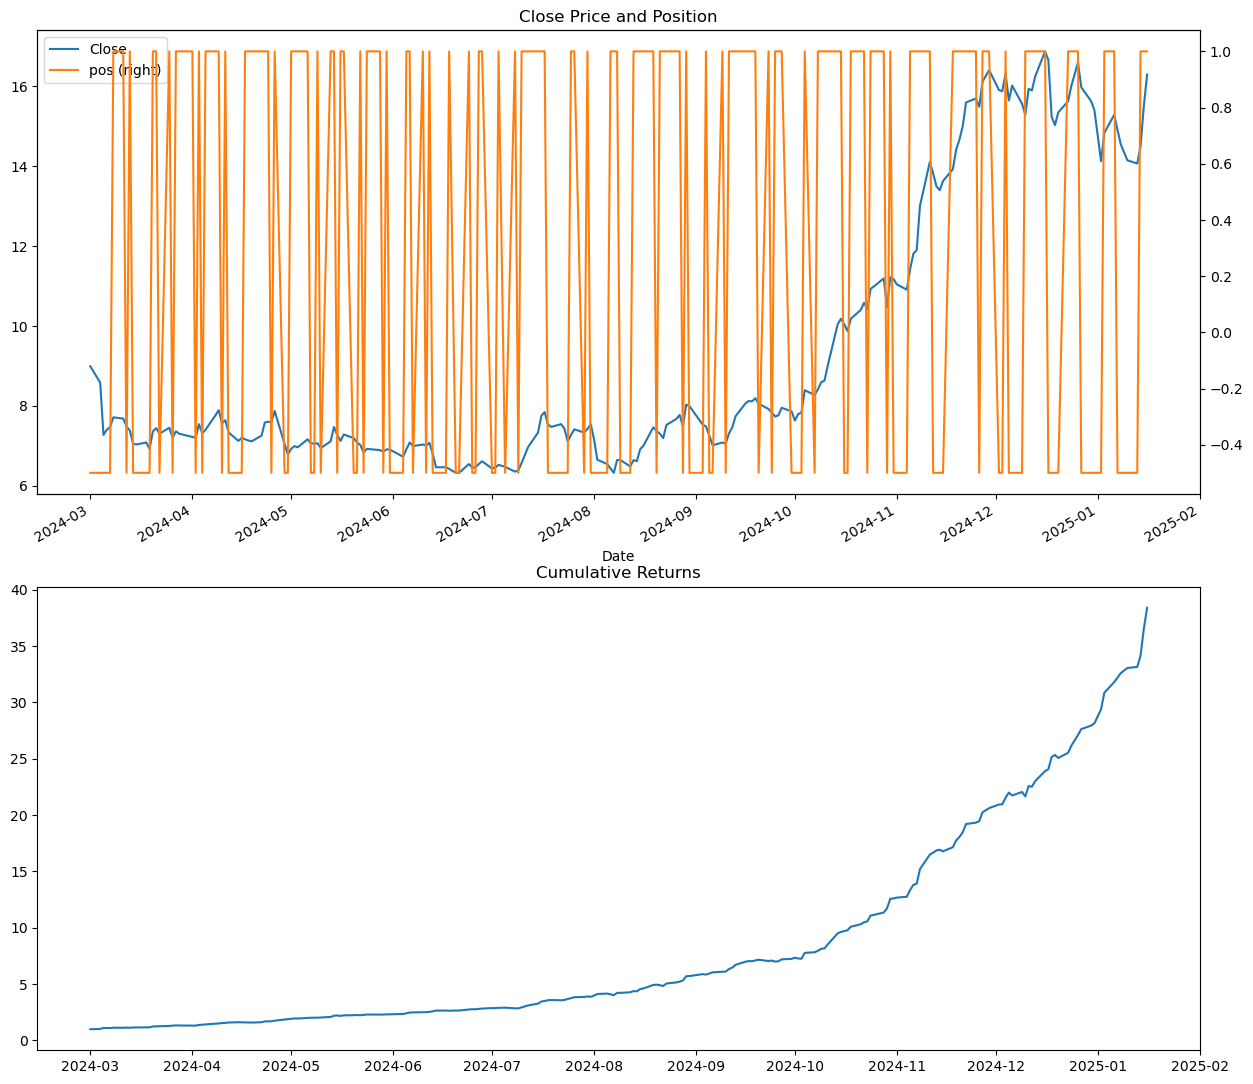

In [15]:
stock = 'SOFI'
src = pd.read_csv(stock + '.csv', parse_dates = True, index_col = 0)
def xgb_strategy(data):
    df1 = data[['Close', 'High', 'Low', 'Open', 'Volume']].copy()
    
    start_date = '2022-01-01'
    end_date = '2024-01-21'
    df2 = yf.download(stock, start=start_date, end=end_date)

    # Make sure data is sorted by date
    df2.sort_index(inplace=True)
    df2 = df2.droplevel(1, axis=1) 

    df = pd.concat((df2, df1)) 

    # Calculate Log Returns
    df['Returns'] = np.log(df['Close'] / df['Close'].shift(1))

    # Drop NaN values
    df.dropna(inplace = True)

    # Simple & Exponential Moving Averages
    df['SMA_10'] = df['Close'].rolling(window = 10).mean()
    df['SMA_50'] = df['Close'].rolling(window = 50).mean()
    df['EMA_20'] = df['Close'].ewm(span = 20, adjust = False).mean()

    # Bollinger Bands (20-day)
    rolling_mean = df['Close'].rolling(window = 20).mean()
    rolling_std = df['Close'].rolling(window = 20).std()
    df['boll_upper'] = rolling_mean + (2 * rolling_std)
    df['boll_lower'] = rolling_mean - (2 * rolling_std)

    # MACD & Signal Line
    df['MACD'] = df['Close'].ewm(span = 12, adjust = False).mean() - df['Close'].ewm(span = 26, adjust = False).mean()
    df['MACD_signal'] = df['MACD'].ewm(span = 9, adjust = False).mean()

    # Average True Range (ATR)
    df['high_low'] = df['High'] - df['Low']
    df['high_close'] = np.abs(df['High'] - df['Close'].shift(1))
    df['low_close'] = np.abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['high_low', 'high_close', 'low_close']].max(axis=1)
    df['ATR'] = df['TR'].rolling(window = 14).mean()

    # ADX (Directional Movement Index)
    df['DM_plus'] = np.where((df['High'] - df['High'].shift(1)) > (df['Low'].shift(1) - df['Low']), 
                             np.maximum(df['High'] - df['High'].shift(1), 0), 0)
    df['DM_minus'] = np.where((df['Low'].shift(1) - df['Low']) > (df['High'] - df['High'].shift(1)), 
                              np.maximum(df['Low'].shift(1) - df['Low'], 0), 0)
    df['DI_plus'] = 100 * (df['DM_plus'].rolling(window = 14).mean() / df['ATR'])
    df['DI_minus'] = 100 * (df['DM_minus'].rolling(window = 14).mean() / df['ATR'])
    df['DX'] = (np.abs(df['DI_plus'] - df['DI_minus']) / (df['DI_plus'] + df['DI_minus'])) * 100
    df['ADX'] = df['DX'].rolling(window = 14).mean()

    # Stochastic Oscillator (14-day)
    df['stoch_k'] = ((df['Close'] - df['Low'].rolling(window = 14).min()) /
                     (df['High'].rolling(window = 14).max() - df['Low'].rolling(window = 14).min())) * 100

    # Williams %R (14-day)
    df['williams_R'] = ((df['High'].rolling(window = 14).max() - df['Close']) /
                         (df['High'].rolling(window = 14).max() - df['Low'].rolling(window = 14).min())) * -100

    # On-Balance Volume (OBV)
    df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()

    # VWAP (Volume Weighted Average Price)
    df['VWAP'] = (df['Close'] * df['Volume']).cumsum() / df['Volume'].cumsum()

    # Lagged Features
    for lag in range(1, 6):
        df[f'lag_{lag}'] = df['Returns'].shift(lag)

    # Time-based Features
    df['day_of_week'] = df.index.dayofweek  # Monday = 0, Sunday = 6
    df['month'] = df.index.month  # 1-12

    # Market Direction (Target)
    
    df['direction'] = (df['Returns'] > 0).astype(int)
        
    # Drop NaN values
    df.dropna(inplace = True)

    # Feature Selection Approaches
    features = [col for col in df.columns if col not in ['Returns', 'direction']]
    train_data = df.loc[:'2024-03-01'].copy()
    X = train_data[features]
    y = train_data['direction']

    # 1. Mutual Information (MI)
    mi_scores = mutual_info_classif(X, y, discrete_features = False)
    mi_selected_features = pd.Series(mi_scores, index = features).nlargest(10).index.tolist()

    # 2. Recursive Feature Elimination (RFE) with RandomForest
    rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
    rfe = RFE(rf, n_features_to_select = 10)
    rfe.fit(X, y)
    rfe_selected_features = X.columns[rfe.support_].tolist()

    # Select Top Features (Union of All Methods)
    final_selected_features = list(set(mi_selected_features) | set(rfe_selected_features))

    # Standardize Features
    scaler = StandardScaler()
    df[final_selected_features] = scaler.fit_transform(df[final_selected_features])

    # Train-Test Split
    train_data = df.loc[:'2024-02-28'].copy()
    test_data = df.loc['2024-03-01':].copy()

    X_train, y_train = train_data[final_selected_features], train_data['direction']
    X_test, y_test = test_data[final_selected_features], test_data['direction']

    # Train XGBoost Model
    model = XGBClassifier(eval_metric="mlogloss")
    model.fit(X_train, y_train)

    # Predict & Compute Strategy Returns
    predictions = model.predict(X_test)
    test_data['pos'] = np.where(predictions == 0, -0.5, 1)
    test_data['xgb_returns'] = test_data['pos'] * test_data['Returns']

    # Compute Cumulative Return
    cumulative_return = np.exp(test_data['xgb_returns'].sum())
    
    # Create a figure with two subplots
    fig, axes = plt.subplots(2, 1, figsize=(15, 15))

    # Plot 'Close' and 'pos' with a secondary y-axis on the first subplot
    test_data[['Close', 'pos']].plot(ax=axes[0], secondary_y='pos')
    axes[0].set_title("Close Price and Position")

    # Plot the cumulative return on the second subplot
    axes[1].plot(np.exp(test_data['xgb_returns'].cumsum()))
    axes[1].set_title("Cumulative Returns")

    print(f"Cumulative Return: {cumulative_return:.4f}") 

xgb_strategy(src)